In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


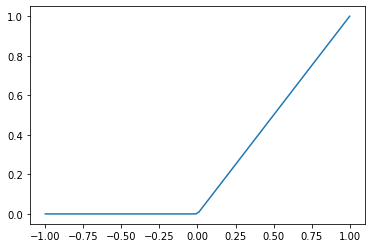

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.2
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.6,0.4]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.D

# Data

In [18]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator
from typing import *
from random import shuffle
    
class RandomBlockPassiveGenerator(BlockPassiveGenerator):
    def generate(self) -> Callable[..., Tensor]:
        bkg_mat = np.random.randint(0,len(self.materials))
        block_mat = bkg_mat
        while block_mat == bkg_mat:
            block_mat = np.random.randint(0,len(self.materials))
            
        base_x0 = X0[self.materials[bkg_mat]]
        block_x0 = X0[self.materials[block_mat]]
        

        block_size = np.random.choice(self.block_size, 3, replace=False)
        block_low = np.hstack((np.random.uniform(high=self.lw[0]-block_size[0]), np.random.uniform(high=self.lw[1]-block_size[1]), np.random.uniform(self.z_range[0], self.z_range[1]-block_size[2])))
        block_high = block_low+block_size

        def generator(*, z: float, lw: Tensor, size: float) -> Tensor:
            shp = (lw / size).long()
            low_xy = np.round(block_low[:2] / size).astype(int)
            high_xy = np.round(block_high[:2] / size).astype(int)
            rad_length = torch.ones(list(shp)) * base_x0
            if z >= block_low[2] and z <= block_high[2]:
                rad_length[low_xy[0] : high_xy[0], low_xy[1] : high_xy[1]] = block_x0
            return rad_length

        return generator, block_mat

In [20]:
g,i = RandomBlockPassiveGenerator(block_size=(0.4,0.4,0.4), lw=(1,1), z_range=(0.2,0.8), sort_x0=False).generate()
for z in [0.8,0.6,0.4]:
    print(g(z=z, lw=volume.lw, size=volume.passive_size),i)

tensor([[0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932]]) 0
tensor([[0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.3528, 0.3528, 0.1932, 0.1932, 0.1932],
        [0.3528, 0.3528, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932]]) 0
tensor([[0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932],
        [0.3528, 0.3528, 0.1932, 0.1932, 0.1932],
        [0.3528, 0.3528, 0.1932, 0.1932, 0.1932],
        [0.1932, 0.1932, 0.1932, 0.1932, 0.1932]]) 0


In [23]:
from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:AbsPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, targ_as_class:bool):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        self.targ_as_class = targ_as_class
        if self.targ_as_class:
            self.class2id = {m:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2class = {i:m for i,m in enumerate(self.passive_generator.materials)}
            self.x02id = {X0[m]:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2x0 = {i:X0[m] for i,m in enumerate(self.passive_generator.materials)}
                
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "pred_x0", "dpoca_x", "dpoca_y", "dpoca_z", "dpoca_r"],
                             'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [], 'row_wise': True}
        self.matrix_feats['feats_per_vec'] = len(self.matrix_feats['present_feats']), 
        self.matrix_feats['shape'] = (self.mu_bs, self.matrix_feats['feats_per_vec'])
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        return torch.tensor(bounds.reshape(3, -1).transpose(-1, -2), dtype=torch.float32) + (self.volume.passive_size/2)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            block, targ = self.passive_generator.generate()
            self.volume.load_rad_length(block)
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, pred[:,None], sb.location), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0)
            data[:,:,-3:] -= self.voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
            data = torch.cat((data,torch.norm(data[:,:,-3:], dim=-1, keepdim=True)), dim=-1)  # dR
            
            # Sort by dR
            idxs = data[:,:,-1].argsort()
            i = np.arange(data.shape[0])[:,None]
            data = data[i,idxs]
            
            inputs.append(data[None,:])
            targets.append(targ)
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        targets = np.array(targets)[:,None]
        if self.targ_as_class:
            for m in self.passive_generator.materials:
                targets[targets == X0[m]] = self.class2id[m]
            targets = targets.astype(int)
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':targets}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [24]:
sy = ScatterYielder(volume=volume, passive_generator=RandomBlockPassiveGenerator(materials=["beryllium","carbon","silicon","iron","lead"], block_size=(0.4,0.4,0.4), lw=(1,1), z_range=(0.2,0.8), sort_x0=False), mu_bs=100, n_volumes_per_fold=160, targ_as_class=True)

In [25]:
sy.n_voxels

75

In [26]:
fold = sy[0]
fold['inputs'][1].shape,fold['targets'].shape

((160, 75, 100, 9), (160, 1))

In [27]:
fold['inputs'][1][0,0,:,-1]

array([0.19072983, 0.21718203, 0.23656125, 0.24700391, 0.29378882,
       0.2955543 , 0.29663962, 0.3012222 , 0.3126998 , 0.32514024,
       0.35003117, 0.3834292 , 0.40290615, 0.4155126 , 0.4158773 ,
       0.41964898, 0.46322888, 0.47029772, 0.47390866, 0.48689535,
       0.4881513 , 0.49212915, 0.49546838, 0.5009163 , 0.507906  ,
       0.5318551 , 0.53554094, 0.5368596 , 0.54379237, 0.54855233,
       0.56511974, 0.5758441 , 0.57894504, 0.5802298 , 0.59531665,
       0.6074717 , 0.6113266 , 0.61168003, 0.61832213, 0.6264364 ,
       0.62908816, 0.63568705, 0.6441228 , 0.6586274 , 0.6626616 ,
       0.68317336, 0.68360955, 0.68546253, 0.6895538 , 0.6981712 ,
       0.7071639 , 0.7077154 , 0.71878886, 0.72127175, 0.7226452 ,
       0.7260821 , 0.7380451 , 0.75281614, 0.75796175, 0.7781645 ,
       0.78093344, 0.7831166 , 0.78569394, 0.7907253 , 0.7967895 ,
       0.8037505 , 0.80543834, 0.8059154 , 0.8069521 , 0.8143899 ,
       0.8179836 , 0.8194863 , 0.8318133 , 0.8361499 , 0.83825

In [28]:
fold['targets']

array([[2],
       [2],
       [0],
       [2],
       [3],
       [1],
       [4],
       [4],
       [3],
       [0],
       [4],
       [0],
       [2],
       [0],
       [2],
       [2],
       [0],
       [3],
       [0],
       [0],
       [3],
       [0],
       [2],
       [4],
       [0],
       [3],
       [1],
       [2],
       [3],
       [3],
       [0],
       [3],
       [1],
       [4],
       [4],
       [1],
       [3],
       [2],
       [1],
       [1],
       [0],
       [4],
       [0],
       [1],
       [3],
       [2],
       [4],
       [2],
       [2],
       [0],
       [3],
       [3],
       [4],
       [3],
       [2],
       [1],
       [3],
       [1],
       [2],
       [2],
       [4],
       [3],
       [3],
       [4],
       [1],
       [4],
       [0],
       [0],
       [3],
       [4],
       [0],
       [2],
       [1],
       [3],
       [3],
       [4],
       [3],
       [2],
       [4],
       [2],
       [3],
       [4],
       [0],
    

# Classifier

In [29]:
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsGraphFeatExtractor
from lumin.nn.models.blocks.gnn_blocks import *
from lumin.nn.models.initialisations import lookup_normal_init
from lumin.nn.models.layers.activations import lookup_act
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d, LCBatchNorm1d, RunningBatchNorm2d

from torch._vmap_internals import _vmap as vmap

class X0Net(AbsGraphFeatExtractor):
    row_wise:Optional[bool] = True
        
    def __init__(self, n_v:int, n_fpv:int, vox_centres:Tensor,
                 do:float=0, rep_bn:bool=False, act:str='relu',
                 lookup_init:Callable[[str,Optional[int],Optional[int]],Callable[[Tensor],None]]=lookup_normal_init,
                 lookup_act:Callable[[str],Any]=lookup_act, bn_class:Callable[[int],nn.Module]=nn.BatchNorm1d, rep_bn_class:Callable[[int],nn.Module]=nn.BatchNorm2d):
        super().__init__(n_v=n_v, n_fpv=n_fpv, do=do, bn=False, act=act, lookup_init=lookup_init, lookup_act=lookup_act, bn_class=bn_class)
        
        self.n_voxels,self.rep_bn,self.rep_bn_class = len(vox_centres),rep_bn,rep_bn_class
                
        # GNNs
        if self.rep_bn: self.init_bn = self.rep_bn_class(self.n_fpv)
        
        self.n_muon_rep, self.n_vox_rep = 40, 40
        self.muon_rep_gnn = GravNet(n_v=self.n_v, n_fpv=self.n_fpv,
                                    cat_means=True,
                                    f_slr_depth=3,
                                    n_s=4,
                                    n_lr=22,
                                    k=25,
                                    f_out_depth=1,
                                    n_out=[48],
                                    act=self.act,
                                    use_sa=False,
                                    bn=False,
                                   )
        self.muon_rep_collapser = GraphCollapser(n_v=self.n_v, n_fpv=self.muon_rep_gnn.get_out_size()[1],
                                                 flatten=False,
                                                 f_final_outs=[self.n_muon_rep],
                                                 n_sa_layers=0,
                                                 global_feat_vec=False,
                                                 act=self.act,
                                                 bn=False,
                                                )
        
        if self.rep_bn: self.muon_rep_bn = self.rep_bn_class(self.muon_rep_collapser.get_out_size()+4)
        
        self.vox_rep_gnn = GravNet(n_v=self.n_voxels, n_fpv=self.muon_rep_collapser.get_out_size()+4,
                                   cat_means=True,
                                   f_slr_depth=3,
                                   n_s=4,
                                   n_lr=22,
                                   k=12,
                                   f_out_depth=1,
                                   n_out=[48],
                                   act=self.act,
                                   use_sa=False,
                                   bn=False,
                                  )
        self.vox_rep_collapser = GraphCollapser(n_v=self.n_voxels, n_fpv=self.vox_rep_gnn.get_out_size()[1],
                                                flatten=False,
                                                f_final_outs=[self.n_vox_rep],
                                                n_sa_layers=0,
                                                global_feat_vec=False,
                                                act=self.act,
                                                bn=False,
                                               )
        
        # Relative voxel positions
        self.vox_centres = vox_centres  # (voxel,coords)
        vox_dists = self.vox_centres[None]-self.vox_centres[:,None]  # (voxel,voxel,coords)
        self.register_buffer('vox_dists', torch.cat((vox_dists,vox_dists.norm(dim=-1, keepdim=True)), dim=-1))
        
    def forward(self, x:Tensor) -> Tensor:
        r'''x=(volume,voxel,muon,feature)'''
        if self.rep_bn: x = self.init_bn(x.transpose(1,-1)).transpose(1,-1)
        
        def get_muon_rep(x:Tensor) -> Tensor:
            r'''(voxel,muon,feature)'''
            return self.muon_rep_collapser(self.muon_rep_gnn(x))
        
#         muon_rep = vmap(get_muon_rep)(x)  # (volume,voxel,muon_rep)
        muon_rep = torch.stack([get_muon_rep(v) for v in x.unbind()], dim=0)  # (volume,voxel,muon_rep)
        muon_rep = muon_rep[:,None].expand(-1,self.n_voxels, -1,-1)  # (volume,voxel,voxel,muon_rep)
        muon_rep = torch.cat((muon_rep, self.vox_dists[None].expand(len(muon_rep), -1, -1, -1)), dim=-1)
        if self.rep_bn: muon_rep = self.muon_rep_bn(muon_rep.transpose(1,-1)).transpose(1,-1)
        
        def get_vox_rep(x:Tensor) -> Tensor:
            r'''(voxel,voxel,muon_rep)'''
            return self.vox_rep_collapser(self.vox_rep_gnn(x))
        
#         vox_rep = vmap(get_vox_rep)(muon_rep)  # (volume,voxel,class)
        vox_rep = torch.stack([get_vox_rep(v) for v in muon_rep.unbind()], dim=0)  # (volume,voxel,class)
        return vox_rep
    
    def get_out_size(self) -> Tuple[int,int]: return self.n_voxels, self.n_vox_rep*2

In [30]:
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.optimisation.hyper_param import lr_find

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(X0Net, vox_centres=sy.voxel_centres, rep_bn=True, rep_bn_class=RunningBatchNorm2d, act='swish'),
               collapser=partial(GraphCollapser,
                                 flatten=True,
                                 f_final_outs=[10],
                                 bn=False,
                                 act='swish',
                                 bn_class=RunningBatchNorm1d
                                ))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('multiclass', cont_feats=sy.matrix_feats['present_feats'], n_out=len(sy.passive_generator.materials), 
                             opt_args=opt_args, body=body, head=head)
print(Model(model_builder))

Inputs:
9 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'pred_x0', 'dpoca_x', 'dpoca_y', 'dpoca_z', 'dpoca_r']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): X0Net(
      (init_bn): RunningBatchNorm2d()
      (muon_rep_gnn): GravNet(
        (grav_layers): ModuleList(
          (0): GravNetLayer(
            (f_slr): Sequential(
              (0): Sequential(
                (0): Linear(in_features=18, out_features=52, bias=True)
                (1): Swish()
              )
              (1): Sequential(
                (0): Linear(in_features=52, out_features=52, bias=True)
                (1): Swish()
              )
              (2): Sequential(
                (0): Linear(in_features=52, out_features=26, bias=True)
                (1): Swish()
              )
            )
            (f_out): Sequential(
              (0): Sequential(
 

In [31]:
sy.get_data_count(0)

160

LR finder took 125.647s 


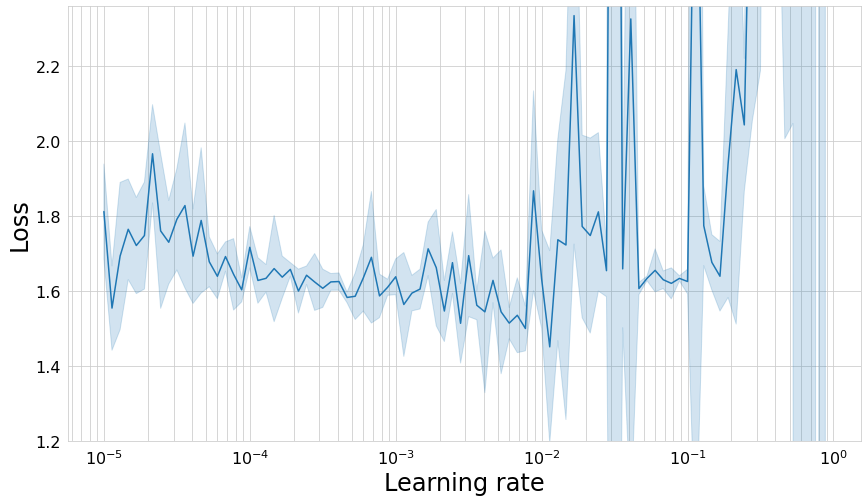

In [32]:
lr_finder = lr_find(sy, model_builder, bs=16, lr_bounds=[1e-5,1e0], n_repeats=3, bulk_move=False)

In [33]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import RocAucScore
from functools import partial

cb_partials = [partial(OneCycle, lengths=[10, 20],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = (partial(RocAucScore, average='weighted', multi_class='ovr'))

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


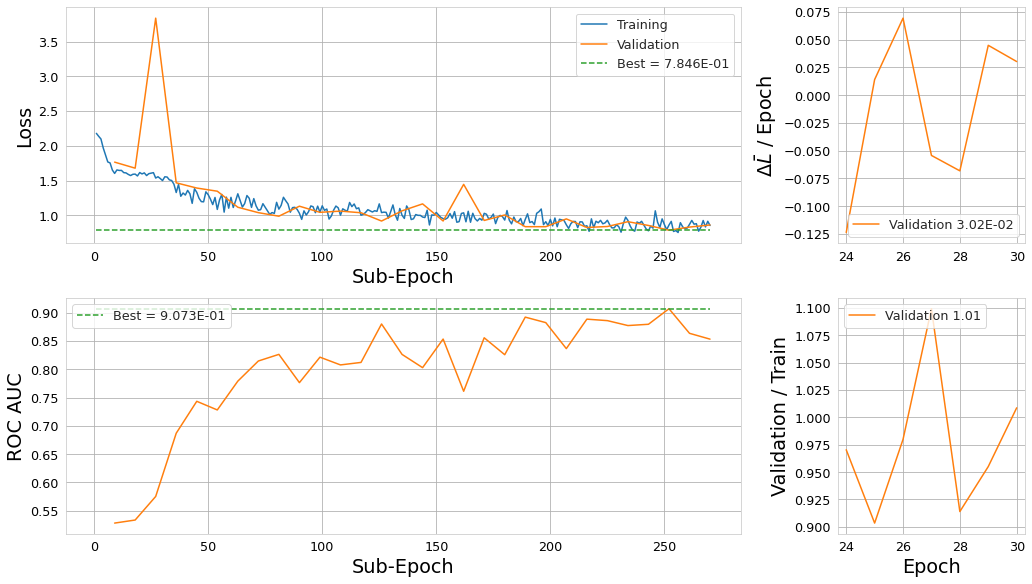

Loading best model with metric value -9.073E-01
Model took 1432.579s

Scores are: {'loss': 0.7845737338066101, 'ROC AUC': 0.9073004993672662}

______________________________________
Training finished
Cross-validation took 1432.688s 


<Figure size 1024x576 with 0 Axes>

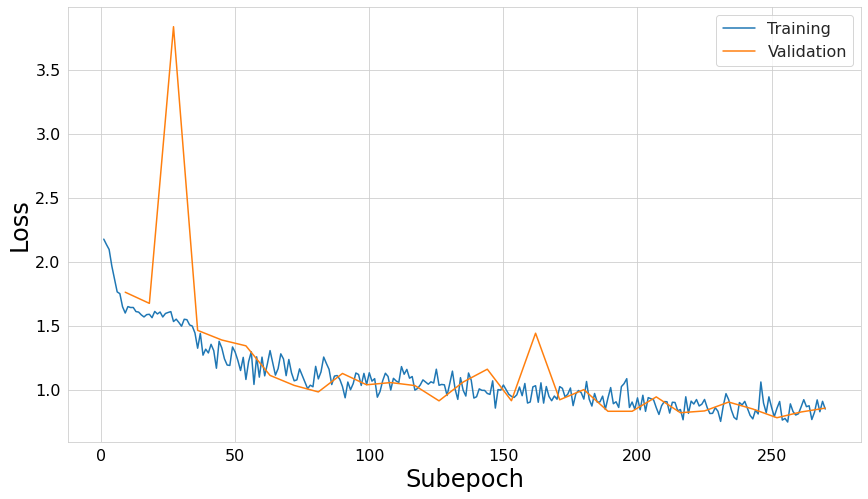

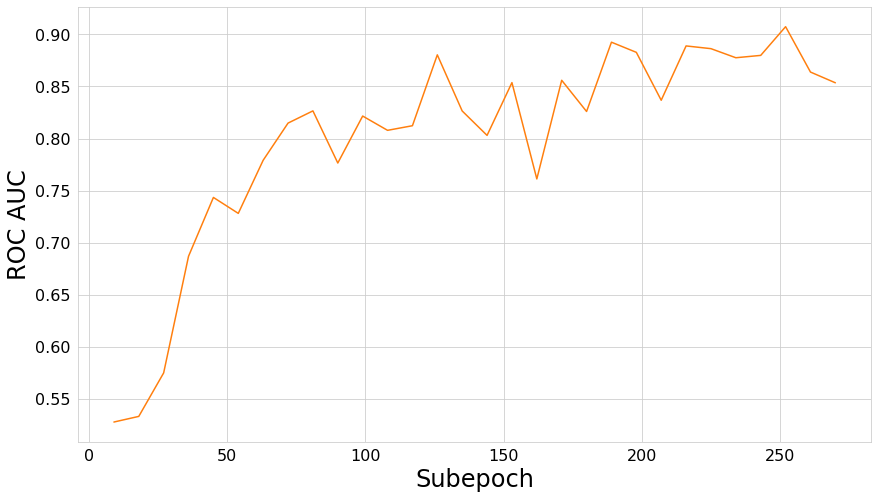

Mean loss = 0.7845737338066101±0.0
Mean ROC AUC = 0.9073004993672662±0.0
______________________________________



In [34]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=16,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=30,
                 bulk_move=False)

In [35]:
model = Model.from_save('train_weights/model_id_0/best.h5', model_builder)

In [36]:
data = sy[0]

In [37]:
pred = model.predict(data['inputs'])

In [38]:
pred

array([[4.17861418e-04, 1.19650307e-04, 4.05411905e-04, 1.30275218e-02,
        9.86029506e-01],
       [1.29401252e-01, 1.29150525e-01, 1.35748118e-01, 1.36541389e-02,
        5.92046022e-01],
       [2.50313205e-05, 7.64149263e-06, 1.20487975e-05, 4.40687593e-03,
        9.95548368e-01],
       [5.23097992e-01, 3.33026528e-01, 1.22896455e-01, 2.06654221e-02,
        3.13672936e-04],
       [2.98798561e-01, 3.15625638e-01, 2.89007485e-01, 1.38675247e-03,
        9.51817036e-02],
       [2.03301534e-01, 3.82560968e-01, 4.13277000e-01, 7.83268653e-04,
        7.72753992e-05],
       [2.10844487e-01, 2.44578227e-01, 2.41765514e-01, 3.01528722e-01,
        1.28304784e-03],
       [5.05168200e-01, 4.42729175e-01, 3.19353342e-02, 1.98159330e-02,
        3.51312425e-04],
       [1.71317952e-03, 1.35354639e-03, 1.37657172e-03, 9.05208886e-01,
        9.03479606e-02],
       [6.03369102e-02, 5.06965294e-02, 6.86452389e-02, 1.44083435e-02,
        8.05912852e-01],
       [2.95172989e-01, 3.0612

In [39]:
data['inputs'][1][0,0]

array([[ 5.57564199e-03,  2.11337954e-03,  3.12587043e-04,
        -8.29757133e-04,  8.36113840e-02, -1.07220575e-01,
        -1.85341164e-02,  1.83499336e-01,  2.13334873e-01],
       [ 1.46487262e-03,  7.04735518e-03,  8.06770171e-04,
         1.55129746e-04,  5.93956485e-02, -1.52329117e-01,
         2.82269195e-02,  2.25177914e-01,  2.73324013e-01],
       [ 3.24006099e-03,  8.17365292e-03, -5.50598663e-04,
        -2.18256086e-04,  3.82818952e-02, -1.48691833e-02,
         8.84936228e-02,  3.05738211e-01,  3.18634689e-01],
       [ 2.67067552e-03,  1.97767513e-03,  3.13725410e-04,
         4.33151552e-04,  2.70954967e-01,  1.66191965e-01,
         3.11112851e-01,  5.12889698e-02,  3.56428862e-01],
       [ 1.99642358e-03,  1.86790526e-03, -1.54585839e-04,
         1.60598749e-04,  4.01579231e-01, -1.44462004e-01,
         3.17154318e-01,  1.09901048e-01,  3.65423560e-01],
       [ 3.25699151e-03,  5.18647581e-03,  5.64084388e-04,
         3.53992888e-04,  7.94873834e-02,  2.450675

In [40]:
pred_class = pred.argmax(-1)
# pred_class = pred > 0.5

In [41]:
pred_class

array([4, 4, 4, 0, 1, 2, 3, 0, 3, 4, 1, 2, 4, 1, 0, 2, 0, 3, 1, 4, 1, 3,
       4, 2, 4, 4, 0, 2, 1, 3, 0, 3, 1, 4, 4, 1, 1, 4, 2, 1, 3, 1, 0, 2,
       1, 1, 3, 0, 3, 4, 1, 4, 1, 3, 1, 4, 1, 4, 0, 3, 3, 0, 4, 4, 3, 4,
       4, 1, 1, 1, 1, 4, 3, 3, 2, 1, 1, 4, 4, 4, 3, 1, 0, 4, 1, 1, 0, 2,
       2, 4, 1, 3, 3, 0, 3, 0, 4, 3, 1, 0, 3, 4, 3, 3, 1, 4, 1, 3, 3, 0,
       3, 2, 3, 4, 3, 1, 3, 1, 3, 1, 1, 0, 2, 1, 1, 4, 2, 0, 2, 0, 2, 1,
       3, 1, 1, 1, 4, 4, 0, 2, 4, 0, 0, 1, 1, 2, 4, 1, 2, 4, 2, 0, 0, 2,
       0, 3, 1, 0, 1, 3])

In [42]:
targs = data['targets'].flatten()

In [43]:
targs

array([4, 4, 4, 2, 0, 1, 3, 0, 3, 4, 0, 2, 1, 1, 1, 2, 2, 3, 1, 3, 2, 3,
       4, 3, 4, 2, 0, 1, 0, 3, 1, 1, 0, 4, 3, 1, 1, 0, 1, 0, 3, 0, 1, 2,
       1, 1, 3, 0, 3, 4, 1, 4, 1, 3, 2, 4, 1, 4, 0, 3, 3, 1, 4, 2, 3, 4,
       2, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 4, 2, 4, 3, 1, 3, 4, 1, 0, 0, 2,
       2, 4, 2, 4, 3, 0, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 4, 0, 3, 3, 1,
       3, 2, 3, 4, 0, 0, 3, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 2, 0,
       3, 1, 1, 1, 4, 4, 0, 0, 4, 0, 0, 0, 1, 3, 4, 0, 0, 4, 2, 0, 0, 0,
       1, 0, 1, 2, 3, 1])

In [44]:
from sklearn.metrics import confusion_matrix, roc_auc_score

In [45]:
confusion_matrix(targs, pred_class)

array([[12, 14,  3,  2,  2],
       [ 7, 24,  5,  3,  2],
       [ 6,  5, 10,  1,  6],
       [ 1,  2,  2, 26,  2],
       [ 0,  0,  0,  1, 24]])

In [46]:
import pandas as pd

Text(0.5, 7.5, 'Predicted')

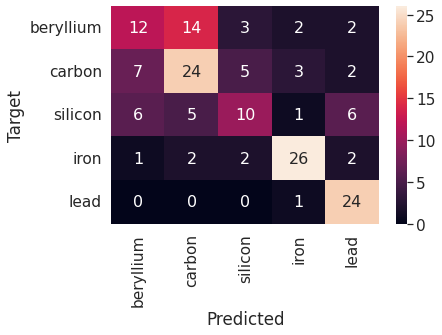

In [47]:
df = pd.DataFrame(confusion_matrix(targs, pred_class), sy.passive_generator.materials, sy.passive_generator.materials)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.ylabel('Target')
plt.xlabel('Predicted')

In [48]:
roc_auc_score(y_true=targs, y_score=pred, multi_class='ovr', average='weighted')

0.8715998367154864